In [4]:
import pandas as pd
import numpy as np
import utils

from sklearn.model_selection import GroupKFold, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import tweedie

from importlib import reload
reload(utils)
from skopt import gp_minimize
%matplotlib inline

In [5]:
train = pd.read_parquet("./train/0.parquet")
train['date'] = pd.to_datetime(train['date'])
train['fold'] = train['date'].dt.month

In [6]:
test = pd.read_csv("test_data.csv", index_col=0).squeeze()

In [7]:
train.dtypes

sku                                int64
date                      datetime64[ns]
sold_quantity                      int64
current_price                    float64
currency                          object
listing_type                      object
shipping_logistic_type            object
shipping_payment                  object
minutes_active                   float64
item_domain_id                    object
site_id                           object
fold                               int64
dtype: object

In [8]:
train.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,item_domain_id,site_id,fold
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,MLB,2
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,MLB,2
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,MLB,2
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,MLB,2
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,MLB,2


In [9]:
def gen_tr_ts():
    for fold in [2,3]:
        ts = train[train['fold'] != fold]['date'].max()
        ts = train[(train['fold'] != fold) & (train['date'] == ts)].index
        yield train.index[train['fold'] == fold], ts, fold

    

In [10]:

def gen_p(na=30., power=1.5):
    dts = list()
    for tr,ts, fold in gen_tr_ts():

        ## EVAL
        pp = train[train['fold'] != fold][['sku', 'date', 'sold_quantity']]
        pp['stock'] = pp['sku'].map(test)
        pp = pp.sort_values(["sku","date"])
        pp['cumulative_y'] = pp.groupby("sku")['sold_quantity'].cumsum()

        pp = pp.dropna(subset=['stock'])
        pp['stockout_y'] = pp['cumulative_y'] >= pp['stock']

        first_so_y = pp[pp['stockout_y']].groupby("sku").first()
        days_to_so_y = (first_so_y["date"] - pp["date"].min()) / np.timedelta64(1, 'D')
        days_to_so_y = days_to_so_y.reindex(pp['sku'].unique()).fillna(na).astype(int).clip(1)
        dts.append(days_to_so_y)

    m = utils.pred_list_to_distro(dts[0], wei=False, total_days=max(na, 30), phi=2, power=power)
    f = utils.pred_list_to_distro(dts[1].reindex(dts[0].index).fillna(dts[0]), wei=False, total_days=max(na, 30), phi=2, power=power)

    m = pd.DataFrame(m,index=dts[0].index)
    f = pd.DataFrame(f,index=dts[0].index)

    p = (m + f)/2

    p = p.div(p.sum(axis=1), axis=0)

    p = p.loc[test.index]
    
    p = p.round(4)

    return p

In [11]:
r = {i:gen_p(30, power=i/10) for i in range(11,20,1)}


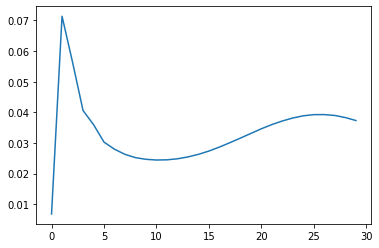

In [52]:
r[11].mean(axis=0).plot()

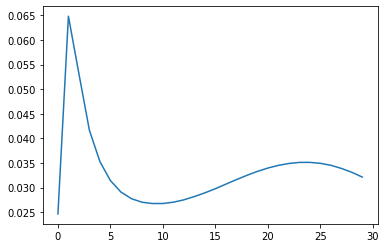

In [53]:
r[12].mean(axis=0).plot()

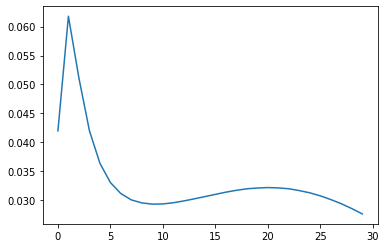

In [13]:
r[13].mean(axis=0).plot()

In [59]:
# phi=2, power=1.3, na=30
r[13].round(4).to_csv("32b.csv.gz", header=False, index=False, compression="gzip")
# LB 4.94

In [ ]:
# BONUS
# xgb 19 + baseline 32 / 2 - LB 4.44